In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
def strip_or_change_dtype(lst):
    for i in range(len(lst)):
        lst[i] = lst[i].strip('"')
        try:
            lst[i] = int(lst[i])
        except:
            try:
                lst[i] = float(lst[i])
            except:
                pass
    return lst

In [3]:
POWER = 'Power [W]'
IPC = 'Instruction throughput\n[instructions per cycle per core]'
FREQ = 'Core frequency [MHz]'
ACTUAL_FREQ = 'Actual core frequency [GHz]'

In [4]:
path = 'datafiles_L1_L:1'
freqs = listdir(path)

plot_df = pd.DataFrame()

for freq in freqs:
    files = listdir(join(path, freq))
    for file, filename in zip(map(lambda f: open(join(path, freq, f), 'r'), files), files):
        csv = list(map(lambda s: s.split(','), file.read()[:-1].split('\n')))
        keys, data = csv[0], list(map(strip_or_change_dtype, csv[1:]))
        df = pd.DataFrame()
        for values in data:
            d = dict(zip(keys, values))
            if d['metric'] == 'metricq':
                d['metric'] = POWER
            if d['metric'] == 'perf-ipc':
                d['average'] *= 2
                d['metric'] = IPC
            if d['metric'] == 'perf-freq':
                d['metric'] = ACTUAL_FREQ
            if d['metric'] == 'ipc-estimate':
                continue
            d[FREQ] = freq
            df = df.append(d, ignore_index=True)
        df['line_count'] = int(filename.split('.')[0])
        plot_df = plot_df.append(df, ignore_index=True)

plot_df

,Core frequency [MHz],average,duration_ms,metric,num_timepoints,stddev,line_count
0,2500,376.32300,4064.0,Power [W],82.0,1.821010,4500
1,2500,2.38039,3902.0,Actual core frequency [GHz],40.0,0.001470,4500
2,2500,3.97262,4002.0,Instruction throughput\n[instructions per cycl...,41.0,0.000311,4500
3,2500,375.24900,4017.0,Power [W],81.0,0.418803,3150
4,2500,2.37968,3902.0,Actual core frequency [GHz],40.0,0.000964,3150
...,...,...,...,...,...,...,...
1804,2200,2.19660,3902.0,Actual core frequency [GHz],40.0,0.000629,6900
1805,2200,3.97792,4002.0,Instruction throughput\n[instructions per cycl...,41.0,0.000256,6900
1806,2200,337.83300,4448.0,Power [W],90.0,0.334902,3850
1807,2200,2.19662,4302.0,Actual core frequency [GHz],44.0,0.000438,3850


In [5]:
BYTES = 'Size of inner loop [B]'
plot_df = plot_df[plot_df['metric'] != ACTUAL_FREQ]
# XXX: 15B for REG, 16B for L1_L and L1_LS_256
plot_df[BYTES] = 2*23 + 16 * plot_df['line_count']
#plot_df
plot_df.to_csv('data_tmp.csv')

LINECOUNT='unroll factor (--set-line-count)'
plot_df.rename(columns = {'line_count':LINECOUNT}, inplace = True)

mask = plot_df.metric.isin([POWER])
scale = plot_df[~mask].average.mean() / float(plot_df[mask].average.mean())
plot_df.loc[mask, 'average'] = plot_df.loc[mask, 'average']*scale

<ipython-input-5-1a64f423ea74>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[BYTES] = 2*23 + 16 * plot_df['line_count']
/nix/store/5p2434cdflzynhfhz0bg0rb2blm1kf63-python3-3.9.4-env/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/nix/store/5p2434cdflzynhfhz0bg0rb2blm1kf63-python3-3.9.4-env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

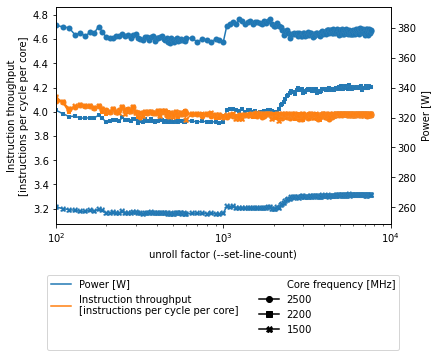

In [6]:
ax1 = sns.lineplot(data=plot_df, x=LINECOUNT, y='average', hue='metric', style=FREQ, dashes=False, markers=True, markeredgewidth=0.2, markeredgecolor=(.8, .8, .8, .2))

ax1.set_xscale('log')
ax1.set_ylabel(IPC)
ax2 = ax1.twinx()

ax1.set_xlim((100,1E4))

ax2.set_ylim(list(map(lambda l: l/scale, ax1.get_ylim())))
ax2.set_ylabel(POWER)
    
handles = ax1.legend().legendHandles[1:3]
handles.append(mlines.Line2D([], [], color='black', label='', linestyle='None'))
handles.append(mlines.Line2D([], [], color='black', label='', linestyle='None'))
handles.append(mlines.Line2D([], [], color='black', label=FREQ, linestyle='None'))
handles.append(mlines.Line2D([], [], marker='o', color='black', label='2500'))
handles.append(mlines.Line2D([], [], marker='s', color='black', label='2200'))
handles.append(mlines.Line2D([], [], marker='X', color='black', label='1500'))

ax1.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5,-0.6), ncol=2)
plt.savefig('../../paper/fig/conway_unroll.pdf', bbox_inches='tight')